In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append("../src/utils")
from utils import SimpleGraphVoltDatasetLoader, read_and_prepare_data
from torch_geometric_temporal.signal import temporal_signal_split
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import A3TGCN
from tqdm import tqdm

In [2]:
model_name = 'A3TGCN_20231211002327.pt'
trafo_id = "T1330"
num_timesteps_in = 12
num_timesteps_out = 4
train_ratio = 0.7
test_ratio_vs_eval_ratio = 0.5

In [3]:
print("Loading data...")
loader = SimpleGraphVoltDatasetLoader(trafo_id)
loader_data = loader.get_dataset(num_timesteps_in=num_timesteps_in, num_timesteps_out=num_timesteps_out)

train_dataset, test_eval_dataset = temporal_signal_split(loader_data, train_ratio=train_ratio)
test_dataset, eval_dataset = temporal_signal_split(test_eval_dataset, train_ratio=test_ratio_vs_eval_ratio)


Loading data...
Voltage index: 5
Voltage index: 5


In [4]:
for node, df in loader._df_measurments.groupby("date_time"):
    #if node == 0:
    #get index of voltade column
        voltage_ind = df.drop(columns=["date_time", "node_id"]).columns.get_loc("voltage") 
        display(df.columns)
        print(voltage_ind)
        break

Index(['node_id', 'power_production', 'power_consumption', 'PMO', 'TR',
       'junction', 'date_time', 'voltage', 'temperature_2m', 'snow_depth',
       'cloud_cover', 'is_day', 'shortwave_radiation', 'direct_radiation',
       'diffuse_radiation', 'direct_normal_irradiance', 'active_power',
       'reactive_power', 'year', 'month', 'day', 'hour', 'minute'],
      dtype='object')

5


In [5]:
loader.dfs.shape

(113, 21, 70080)

In [6]:
loader.dfs[30, 5, :]

array([0.86982679, 0.84471628, 0.93080946, ..., 0.45729697, 0.41066316,
       0.48599469])

In [7]:
eval_dataset[0]

Data(x=[113, 21, 12], edge_index=[2, 114], edge_attr=[114, 5], y=[113, 4])

In [12]:


class TemporalGNN(torch.nn.Module):
    def __init__(self, node_features, periods):
        super(TemporalGNN, self).__init__()
        # Attention Temporal Graph Convolutional Cell
        out_channels = 32
        self.tgnn = A3TGCN(in_channels=node_features, 
                           out_channels=out_channels, 
                           periods=periods)
        # Equals single-shot prediction
        self.linear = torch.nn.Linear(out_channels, periods)

    def forward(self, x, edge_index):
        """
        x = Node features for T time steps
        edge_index = Graph edge indices
        """
        h = self.tgnn(x, edge_index)
        h = F.relu(h)
        h = self.linear(h)
        return h

In [13]:
#read saved model
device = torch.device('cpu')
model = TemporalGNN(node_features=train_dataset[0].x.shape[1], periods=train_dataset[0].y.shape[1]).to(device)
model.load_state_dict(torch.load(f"../models/{model_name}", map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
node = 50

In [59]:
preds = []
ys = []
model.eval()
with torch.no_grad():
    for snapshot in tqdm(eval_dataset):
        x = snapshot.x
        edge_index = snapshot.edge_index
        y = snapshot.y
        snapshot = snapshot.to(device)
        pred = model(snapshot.x, snapshot.edge_index)
        pred = pred.detach().numpy()
        y = snapshot.y.detach().numpy()
        ys.append(y[node, 0])
        preds.append(pred[node, 0])
plt.plot(ys, label="y")
plt.plot(preds, label="pred")
plt.legend()

In [57]:
dataset = eval_dataset
ind = 1000
x = dataset[ind].x
edge_index = dataset[ind].edge_index
y = dataset[ind].y
node = 1
voltage = 5
x[node, voltage, :]
voltage_std = loader.mean_and_std["measurements"][1]["voltage"]

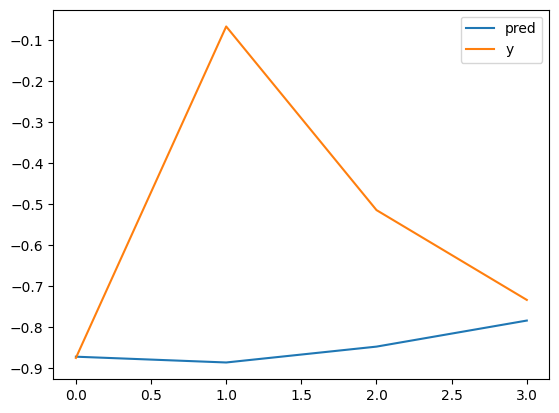

In [58]:
model.eval()
with torch.no_grad():
    pred = model(x, edge_index)
pred_node = pred[node, :]
plt.plot(pred_node*voltage_std, label="pred")
plt.plot(y[node, :]*voltage_std, label="y")
plt.legend()